In [80]:
import torch

In [98]:
a = torch.Tensor([[1,2,3], [1,2,3], [1,2,3], [1,2,3]])
a2 = a.roll(shifts = -1, dims = 1)
a3 = a.roll(shifts = -1, dims = 1)

In [99]:
a, a2, a3

(tensor([[1., 2., 3.],
         [1., 2., 3.],
         [1., 2., 3.],
         [1., 2., 3.]]),
 tensor([[2., 3., 1.],
         [2., 3., 1.],
         [2., 3., 1.],
         [2., 3., 1.]]),
 tensor([[2., 3., 1.],
         [2., 3., 1.],
         [2., 3., 1.],
         [2., 3., 1.]]))

In [103]:
a[0]

tensor([1., 2., 3.])

In [1]:
from src.lerobot.datasets.lerobot_dataset import LeRobotDataset, LeRobotDatasetMetadata
from PIL import Image
import numpy as np
import torch
from transformers import AutoProcessor, Qwen2_5_VLForConditionalGeneration
from lerobot.policies.act.modeling_act import ACTPolicy

* [1] Qwen 호출

In [2]:
model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    "Qwen/Qwen2.5-VL-7B-Instruct",
    torch_dtype=torch.bfloat16,
    #torch_dtype="auto",
    device_map="auto",
    attn_implementation="flash_attention_2",
)
processor = AutoProcessor.from_pretrained("Qwen/Qwen2.5-VL-7B-Instruct", use_fast=True)
processor.tokenizer.padding_side = "left"

#device = torch.device("cuda")

#model.to(device)

#while len(model.model.layers) > 10:
#    model.model.layers.pop(-1)

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

* [2]  dataset 호출

In [3]:
dataset = LeRobotDataset(
    repo_id="lerobot/custom_dataset",
    root='/mnt/d/lerobot_dataset/panda_robot_dataset_lerobot/v1_latent',
    episodes = list(range(700, 1000))
)

Resolving data files:   0%|          | 0/300 [00:00<?, ?it/s]

In [4]:
dataloader = torch.utils.data.DataLoader(
    dataset,
    #num_workers=8,
    batch_size=1,
    shuffle=False,
    #pin_memory=device.type != "cpu",
    drop_last=False,
)

* [3] Qwen prompting

In [5]:
batch = next(iter(dataloader))

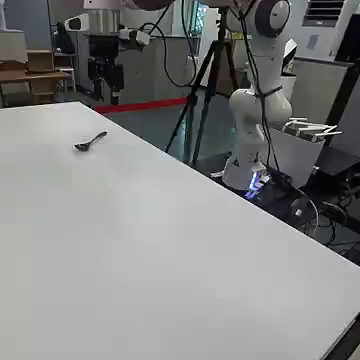

In [6]:
i = 0
Image.fromarray(np.transpose((batch['observation.left_image'][i].numpy() * 255).astype('uint8'), [1, 2, 0]))

In [7]:
def inputs_maker(processor, batch, i):
    ImageSet = []

    tasks = batch['task']
    
    pil_img_m = np.transpose((batch['observation.mid_image'][0].numpy() * 255), [1,2,0])
    pil_img_r = np.transpose((batch['observation.right_image'][0].numpy() * 255), [1,2,0])
    pil_img_l = np.transpose((batch['observation.left_image'][0].numpy() * 255), [1,2,0])

    ImageSet.append(pil_img_m)
    ImageSet.append(pil_img_r)
    ImageSet.append(pil_img_l)
    
    texts = [(
        '<|im_start|>system\n'
        'You are a single-arm gripper-type robot. You have just received the following images from three cameras. '
        'Picture 1: <|vision_start|><|image_pad|><|vision_end|> - Captured by the wrist-mounted camera. '
        'Picture 2: <|vision_start|><|image_pad|><|vision_end|> - Captured by the rear-right camera, showing both the robot and its environment. '
        'Picture 3: <|vision_start|><|image_pad|><|vision_end|> - Captured by the front-left camera, showing both the robot and its environment.<|im_end|>\n'
        '<|im_start|>user\n'
        f'How should you move when you need to {task}?'
        '<|im_start|>assistant\n'
    )
             for task in tasks
            ]
    
    inputs = processor(
        text=texts,
        images=ImageSet,
        padding=True,
        return_tensors="pt",
    )
    inputs = inputs.to(model.device)
    return inputs

def outputs_maker(model, inputs):
    output1 = model.generate(**inputs,
                         max_new_tokens=1,
                         do_sample=False,
                         output_hidden_states=True,
                         return_dict_in_generate=True)
    return output1

In [8]:
import time
st = time.time()
output = outputs_maker(model, inputs_maker(processor, batch, 0))
last_hidden_state_of_1st_token = output['hidden_states'][0][10]
first_token_latent = last_hidden_state_of_1st_token[:, -1, :]  # (batch, hidden)
latent_extracted = first_token_latent.cpu().float().numpy().astype('float16')
cycle = time.time() - st
cycle

/home/etri1234/miniconda3/envs/lerobot_env2/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `1e-06` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


0.3411524295806885

In [9]:
latent_extracted.shape

(1, 3584)

In [31]:
device = 'cuda'
policy = ACTPolicy.from_pretrained("/mnt/d/lerobot/outputs/train/dp_vla_act_panda_robot_v1/checkpoints/000005/pretrained_model").to(device)

Loading weights from local directory


In [32]:
batch['latent'] = latent_extracted
inputs = observation = {
                'latent': torch.from_numpy(latent_extracted).to(device),
                'observation.state': batch['observation.state'].to(device),
                'observation.left_image': batch['observation.left_image'].to(device),
                'observation.right_image': batch['observation.right_image'].to(device),
                'observation.mid_image' : batch['observation.mid_image'].to(device)
            }

In [34]:
policy.select_action(inputs)

tensor([[-0.1112,  0.0397,  0.1683, -1.4329, -0.0163,  1.8507,  0.3700,  0.4841]],
       device='cuda:0')

## [3] sentence_check

In [ ]:
#tasks = batch['task'][:1]
#for IDX in range(1):
#    pil_img_m = Image.fromarray(np.transpose((batch['observation.mid_image'][IDX].numpy() * 255).astype('uint8'), [1, 2, 0]))
#    pil_img_r = Image.fromarray(np.transpose((batch['observation.right_image'][IDX].numpy() * 255).astype('uint8'), [1, 2, 0]))
#    pil_img_l = Image.fromarray(np.transpose((batch['observation.left_image'][IDX].numpy() * 255).astype('uint8'), [1, 2, 0]))
#
#    ImageSet.append(pil_img_m)
#    ImageSet.append(pil_img_r)
#    ImageSet.append(pil_img_l)

#pil_img_m = Image.fromarray(np.transpose((batch['observation.mid_image'][0].numpy() * 255).astype('uint8'), [1, 2, 0]))
#pil_img_r = Image.fromarray(np.transpose((batch['observation.right_image'][0].numpy() * 255).astype('uint8'), [1, 2, 0]))
#pil_img_l = Image.fromarray(np.transpose((batch['observation.left_image'][0].numpy() * 255).astype('uint8'), [1, 2, 0]))

#texts = [(
#    "<|im_start|>system\n"
#     "You are a single-arm gripper-type robot operating in a dynamic environment. "
#     "You have just received three images from different cameras at this current step:\n"
#     "1. Picture 1 (<|vision_start|><|image_pad|><|vision_end|>): Captured by your wrist-mounted camera, providing a close-up of the gripper and nearby objects.\n"
#     "2. Picture 2 (<|vision_start|><|image_pad|><|vision_end|>): Captured by the rear-right camera, offering an overview of you (the robot) and your surroundings.\n"
#     "3. Picture 3 (<|vision_start|><|image_pad|><|vision_end|>): Captured by the front-left camera, presenting another perspective of you and the surrounding environment.\n"
#     "<|im_end|>\n"
#     "<|im_start|>user\n"
#     f"Based on the current images and the intended task of [{task}],\n"
#     "please describe in detailed, specific sentences how you should move. "
#     "Your response should help determine the relative action for this step. \n"
#     "Explain how this previous action informs your next movement in terms of direction, adjustments, and any other relevant parameters.\n"
#     "If the task is finished, then just say 'finished!!'. "
#     "Otherwise, respond with only a one-sentence direction."
#     "<|im_end|>\n"
#     "<|im_start|>assistant\n"
#)
#         for task in tasks
#        ]

#texts = [(
#    "<|im_start|>system\n"
#     "You are a single-arm gripper-type robot operating in a dynamic environment. "
#     "You have just received three images from different cameras at this current step:\n"
#     "1. Picture 1 (<|vision_start|><|image_pad|><|vision_end|>): Captured by your wrist-mounted camera, providing a close-up of the gripper and nearby objects.\n"
#     "2. Picture 2 (<|vision_start|><|image_pad|><|vision_end|>): Captured by the rear-right camera, offering an overview of you (the robot) and your surroundings.\n"
#     "3. Picture 3 (<|vision_start|><|image_pad|><|vision_end|>): Captured by the front-left camera, presenting another perspective of you and the surrounding environment.\n"
#     "<|im_end|>\n"
#     "<|im_start|>user\n"
#     f"Based on the current images and the intended task of [{task}],\n"
#     "Here is a current task description: {current_task}. Generate a very short, clear, and complete one-sentence"
#     "describing the action performed by the robot arm. Do not include unnecessary words."
#     "Be concise."
#     "Here is some examples: Pick up the cube and place it in the box, open the drawer and so on."
#     "Start directly with an action verb like “Pick”, “Place”, “Open”, etc."
#     "Similar to the provided examples, what is the main action done by the robot arm?"
#     "<|im_end|>\n"
#     "<|im_start|>assistant\n"
#)
#         for task in tasks
#        ]
    
#texts = [(
#    '<|im_start|>system'
#    'You are a single-arm gripper-type robot operating in a dynamic environment. '
#    'At this step, you have received three images from different cameras:'
#    '1. Picture 1 (<|vision_start|><|image_pad|><|vision_end|>): Wrist-mounted camera, close-up of the gripper and nearby objects.'
#    '2. Picture 2 (<|vision_start|><|image_pad|><|vision_end|>): Rear-right camera, overview of the robot and its surroundings.'
#    '3. Picture 3 (<|vision_start|><|image_pad|><|vision_end|>): Front-left camera, another perspective of the robot and environment.'
#    'Use these images together to reason about spatial relations, object positions, and environmental context.'
#    '<|im_end|>'
#    
#    '<|im_start|>user\n'
#    f'Based on the current images and the intended task of [{task}], do the following:\n'
#    
#    '1. **Analyze the situation**: Describe in clear, specific sentences what you see in the images (objects, positions, obstacles, orientation of the gripper, etc.).'
#    '2. **Decide the next action**: Explain how the previous action informs the next movement. Be explicit about direction (left, right, forward, backward, up, down), rotation, distance, or force adjustments.'
#    '3. **Action output format**:'
#       '- If the task is completed: respond only with the word **"finished!!"**.'
#       '- Otherwise: respond with **exactly one concise sentence** describing the next relative action (e.g., "Move the gripper slightly forward and lower").'
#    
#    'Your response must always follow these rules strictly.'
#    '<|im_end|>\n'
#    '<|im_start|>assistant\n'
#    )
#         for task in tasks
#        ]    

In [97]:
# Inference: Generation of the output
inputs = inputs_maker(processor, batch, 0)

with torch.no_grad():
    generated_ids = model.generate(**inputs, max_new_tokens=1024)

generated_ids_trimmed = [
    out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
]

output_text = processor.batch_decode(
generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
)
print(output_text)

['Pick up the wooden spoon.', 'Pick up the wooden spoon.', 'Pick up the wooden spoon.', 'Pick up the wooden spoon.', 'Pick up the wooden spoon.', 'Pick up the wooden spoon.', 'Pick up the wooden spoon.', 'Pick up the wooden spoon.', 'Pick up the wooden spoon.', 'Pick up the wooden spoon.', 'Pick up the wooden spoon.', 'Pick up the wooden spoon.', 'Pick up the wooden spoon.', 'Pick up the wooden spoon.', 'Pick up the wooden spoon.', 'Pick up the wooden spoon.', 'Pick up the wooden spoon.', 'Pick up the wooden spoon.', 'Pick up the wooden spoon.', 'Pick up the wooden spoon.', 'Pick up the wooden spoon.', 'Pick up the wooden spoon.', 'Pick up the wooden spoon.', 'Pick up the wooden spoon.', 'Pick up the wooden spoon.', 'Pick up the wooden spoon.', 'Pick up the wooden spoon.', 'Pick up the wooden spoon.', 'Pick up the wooden spoon.', 'Pick up the wooden spoon.', 'Pick up the wooden spoon.', 'Pick up the wooden spoon.', 'Pick up the wooden spoon.', 'Pick up the wooden spoon.', 'Pick up the 

In [147]:
inputs = inputs_maker(processor, batch, 0)

with torch.no_grad():
    generated_ids = model.generate(**inputs, max_new_tokens=1)

generated_ids_trimmed = [
    out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
]

output_text = processor.batch_decode(
generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
)
print(output_text)

['To', 'To', 'To', 'To', 'To', 'To', 'To', 'To', 'To', 'To', 'To', 'To', 'To', 'To', 'To', 'To', 'To', 'To', 'To', 'To', 'To', 'To', 'To', 'To', 'To', 'To', 'To', 'To', 'To', 'To', 'To', 'To', 'To', 'To', 'To', 'To', 'To', 'To', 'To', 'To', 'To', 'To', 'To', 'To', 'To', 'To', 'To', 'To', 'To', 'To', 'To', 'To', 'To', 'To', 'To', 'To', 'To', 'To', 'To', 'To', 'To', 'To', 'To', 'To']


In [155]:
for k, _ in output.items():
    print(k)

sequences
hidden_states
past_key_values


In [159]:
output['hidden_states'][0][-1]

tensor([[[ 3.9453e-01,  6.9141e-01, -9.2188e-01,  ..., -6.3438e+00,
          -1.1094e+00, -1.4375e+00],
         [-2.5000e-01,  8.7500e-01,  6.7969e-01,  ..., -3.0156e+00,
          -3.2969e+00, -8.4375e-01],
         [ 2.1094e+00,  4.9688e+00,  2.0938e+00,  ...,  2.0938e+00,
           1.5625e+00,  3.7656e+00],
         ...,
         [ 5.6562e+00, -4.1250e+00,  1.3906e+00,  ...,  2.2363e-01,
          -1.3750e+00,  5.2344e-01],
         [ 1.2344e+00, -8.9062e-01,  4.6875e-01,  ..., -2.4121e-01,
           2.9883e-01,  5.9375e-01],
         [-1.1562e+00, -2.2812e+00,  2.1250e+00,  ...,  1.3672e+00,
          -2.6094e+00,  1.6719e+00]],

        [[ 3.9453e-01,  6.9141e-01, -9.2188e-01,  ..., -6.3438e+00,
          -1.1094e+00, -1.4375e+00],
         [-2.5000e-01,  8.7500e-01,  6.7969e-01,  ..., -3.0156e+00,
          -3.2969e+00, -8.4375e-01],
         [ 2.1094e+00,  4.9688e+00,  2.0938e+00,  ...,  2.0938e+00,
           1.5625e+00,  3.7656e+00],
         ...,
         [ 5.5625e+00, -4

In [51]:
inputs = inputs_maker(processor, batch, 0)

In [52]:
inputs

{'input_ids': tensor([[151644,   8948,    198,   2610,    525,    264,   3175,  66818,  22993,
           6922,  10604,  12305,     13,   1446,    614,   1101,   3949,    279,
           2701,   5335,    504,   2326,  18139,     13,  24568,    220,     16,
             25,    220, 151652, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         15165

## [4] FPS 계산 

In [10]:
inputs = inputs_maker(processor, batch, 0)

In [12]:
import time
import torch

# warmup (GPU 첫 호출 오버헤드 제거)
_ = model.generate(**inputs, max_new_tokens=1)

# 반복 횟수
num_iters = 100
torch.cuda.synchronize()
start = time.time()

inputs = inputs_maker(processor, batch, 0)

for _ in range(num_iters):
    out = model.generate(
        **inputs,
        max_new_tokens=1,
        do_sample=False,
    )

torch.cuda.synchronize()
end = time.time()

elapsed = end - start
avg_time = elapsed / num_iters
fps = 1.0 / avg_time  # "초당 1토큰" 기준 FPS

print(f"Elapsed: {elapsed:.3f}s for {num_iters} iters")
print(f"Avg time per generate step: {avg_time*1000:.2f} ms")
print(f"FPS (tokens/s): {fps:.2f}")

Elapsed: 6.853s for 100 iters
Avg time per generate step: 68.53 ms
FPS (tokens/s): 14.59


In [10]:
from tqdm.notebook import tqdm

In [13]:
import torch, time
model.eval()
torch.set_grad_enabled(False)

# 더 정밀한 CUDA 타이밍 (time.time 대신)
starter = torch.cuda.Event(enable_timing=True)
ender   = torch.cuda.Event(enable_timing=True)

# warmup 여러 번 권장
#for _ in range(100):
#    _ = model.generate(**inputs, max_new_tokens=1, do_sample=False)

iters = 350
torch.cuda.synchronize()
starter.record()
with torch.no_grad():
    for _ in tqdm(range(iters)):
        inputs = inputs_maker(processor, batch, 0)
        _ = model.generate(**inputs, max_new_tokens=1, do_sample=False)
ender.record()
torch.cuda.synchronize()

ms = starter.elapsed_time(ender)                 # 총 ms
avg_ms = ms / iters
fps = 1000.0 / avg_ms                            # tokens/s (배치당 1토큰)
print(f"Avg per-step: {avg_ms:.2f} ms, FPS: {fps:.2f}")

  0%|          | 0/1000 [00:00<?, ?it/s]

Avg per-step: 72.72 ms, FPS: 13.75


In [100]:
66.7*10

667.0

In [11]:
while len(model.model.layers) > 10:
    model.model.layers.pop(-1)

In [17]:
output1 = model.generate(**inputs,
              max_new_tokens = 1,
              do_sample = False,
              output_hidden_states = True,
              return_dict_in_generate = True)['hidden_states'][0][10][:, -1, :]

In [21]:
output1

tensor([[ 0.6484,  0.0037,  1.8750,  ..., -0.8438, -0.0493, -1.9766]],
       device='cuda:0', dtype=torch.bfloat16)

In [22]:
latent_extracted

array([[ 0.1719  ,  0.000977,  0.496   , ..., -0.2148  , -0.01318 ,
        -0.5273  ]], shape=(1, 3584), dtype=float16)

In [29]:
?model.generate

Signature:
model.generate(
    inputs: Optional[torch.Tensor] = None,
    generation_config: Optional[transformers.generation.configuration_utils.GenerationConfig] = None,
    logits_processor: Optional[transformers.generation.logits_process.LogitsProcessorList] = None,
    stopping_criteria: Optional[transformers.generation.stopping_criteria.StoppingCriteriaList] = None,
    prefix_allowed_tokens_fn: Optional[Callable[[int, torch.Tensor], List[int]]] = None,
    synced_gpus: Optional[bool] = None,
    assistant_model: Optional[ForwardRef('PreTrainedModel')] = None,
    streamer: Optional[ForwardRef('BaseStreamer')] = None,
    negative_prompt_ids: Optional[torch.Tensor] = None,
    negative_prompt_attention_mask: Optional[torch.Tensor] = None,
    use_model_defaults: Optional[bool] = None,
    **kwargs,
) -> Union[transformers.generation.utils.GenerateDecoderOnlyOutput, transformers.generation.utils.GenerateEncoderDecoderOutput, transformers.generation.utils.GenerateBeamDecoderOnlyOut

In [ ]:
?model./